In [1]:
from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count

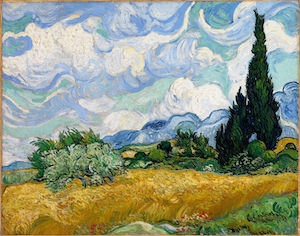

In [2]:
display(REFERENCE_IMAGE)

In [3]:
# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

In [4]:
def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}.png")

def run_algorithm(settings):
    seed, population_size, crossover_method, num_points, initialization, mutation, selection, generation_budget = settings
    start = time()
    
    data = []
    evo = Evolution(num_points,
                    REFERENCE_IMAGE,
                    population_size=population_size,
                    generation_reporter=reporter,
                    crossover_method=crossover_method,
                    seed=seed,
                    initialization=initialization,
                    mutation_method=mutation,
                    generation_budget=generation_budget,
                    num_features_mutation_strength=.25,
                    mutation_method=mutation,
                    selection_name=selection,
                    verbose=verbose_output)
    data = evo.run()
    time_spent = time() - start
    print(f"Done: run {seed} - pop {population_size} - crossover {crossover_method} - num. points {num_points} - initialization {initialization} - in {int(time_spent)} seconds")
    
    return data

## Running a single instance

## Running a sweep of settings

In [6]:
%%time

generation_budget = 500
 
data = []
for seed in range(1):
    for population_size in (100, 300):
        for crossover_method in ("UNIFORM", "ONE_POINT", "TWO_POINT", "THREE_POINT"):
            for initialization in ("MATCH",):
                for mutation in ("ADD_RANDOM", "SCRAMBLE", "SHRINK"):
                    for selection in ("tournament_4",):
                        for num_points in (100,):
                            data.extend(run_algorithm((seed, population_size, crossover_method, num_points, initialization, mutation, selection, generation_budget)))

MATCH
This is the elite 5:[ 29  21 126 187 188]
number of elites that are kept: 20
generation: 1 best fitness: 78432 avg. fitness: 50958.26
This is the elite 5:[ 41  30 196 151  33]
number of elites that are kept: 20
generation: 2 best fitness: 77677 avg. fitness: 51129.1
This is the elite 5:[ 25  18 194 198 206]
number of elites that are kept: 20
generation: 3 best fitness: 45207 avg. fitness: 50656.26
number of elites that are kept: 20
generation: 4 best fitness: 45207 avg. fitness: 49500.78
This is the elite 5:[ 20  27  90 106  79]
number of elites that are kept: 20
generation: 5 best fitness: 44633 avg. fitness: 47287.43
This is the elite 5:[ 20  27  90 106  79]
number of elites that are kept: 20
generation: 6 best fitness: 44237 avg. fitness: 47101.55
number of elites that are kept: 20
generation: 7 best fitness: 44237 avg. fitness: 45277.36
This is the elite 5:[ 20  27  90 106  79]
number of elites that are kept: 20
generation: 8 best fitness: 44138 avg. fitness: 44497.55
This is

## Evaluating the results

## Running a sweep of settings

In [7]:
df = pd.DataFrame(data)
df["time-elapsed"] = df["time-elapsed"].round(0)

   num-generations  num-evaluations  time-elapsed  best-fitness  \
0                1              200           0.0         78432   
1                2              300           0.0         77677   
2                3              400           0.0         45207   
3                4              500           1.0         45207   
4                5              600           1.0         44633   

  crossover-method  population-size  num-points initialization  \
0          UNIFORM              100         100          MATCH   
1          UNIFORM              100         100          MATCH   
2          UNIFORM              100         100          MATCH   
3          UNIFORM              100         100          MATCH   
4          UNIFORM              100         100          MATCH   

  mutation-method     selection  seed  
0      ADD_RANDOM  tournament_4     0  
1      ADD_RANDOM  tournament_4     0  
2      ADD_RANDOM  tournament_4     0  
3      ADD_RANDOM  tournament_4     0  


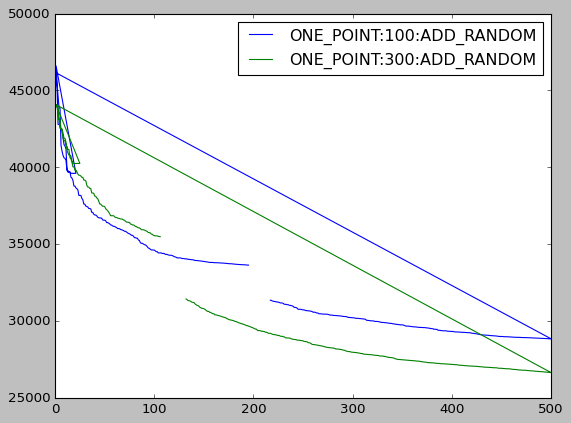

In [14]:
num_simulations = len(df) // generation_budget

print(df.head())

# Iterate over the simulations and create separate DataFrames
simulations = {}
for i in range(num_simulations):
    start_index = i * 500
    end_index = (i + 1) * 500
    simulations[f"sim{i}"] = df[start_index:end_index]

for simulation_id, simulation_data in simulations.items():
    if(simulation_data["crossover-method"].unique()[0] in ("TWO_POINT",) 
       and simulation_data["mutation-method"].unique()[0] not in ("SCRAMBLE", "SHRINK")):
        plt.plot(simulation_data["num-generations"], simulation_data["best-fitness"], label=(simulation_data["crossover-method"].unique()[0]+":"+
                                                                                            str(simulation_data["population-size"].unique()[0])+":"+
                                                                                            simulation_data["mutation-method"].unique()[0]))
plt.legend()
plt.show()

## Displaying the best instances over time

In [ ]:
def show_progress_over_time(settings, selection=None, grid=(5,4)):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid,
                     axes_pad=0.1,  # pad between axes
                     )

    if selection is None:
        selection = range(50, generation_budget + 50, 50)
    
    img_arr = [Image.open((f"./img/van_gogh_intermediate_{seed}_{population_size}_{crossover_method}_{num_points}_{initialization}_{generation_budget}_{i:05d}.png")) for i in selection]
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
show_progress_over_time((0, 100, 'ONE_POINT', 100, "RANDOM", 500), grid=(1,5))

In [ ]:
%%time
data = run_algorithm((0, 100, "UNIFORM", 100, 'MATCH', 500))

[[  9  19 151 ... 217 117 207]
 [ 34   6 100 ... 147 137 101]
 [ 22  32 253 ...  39 173   5]
 ...
 [ 32  18 224 ...  37 255  21]
 [ 19   5  20 ... 104 144 110]
 [ 44  31 173 ... 103   0 120]] (300, 500)
generation: 1 best fitness: 131972 avg. fitness: 144814.43333333332
generation: 2 best fitness: 130688 avg. fitness: 140007.71666666667
generation: 3 best fitness: 125234 avg. fitness: 136700.47666666665
generation: 4 best fitness: 125234 avg. fitness: 134144.67
generation: 5 best fitness: 123281 avg. fitness: 132371.81666666668
generation: 6 best fitness: 123281 avg. fitness: 130771.73666666666
generation: 7 best fitness: 123183 avg. fitness: 128958.23666666666
generation: 8 best fitness: 120514 avg. fitness: 127369.55666666667
generation: 9 best fitness: 119552 avg. fitness: 125714.35666666667
generation: 10 best fitness: 118181 avg. fitness: 124487.08666666667
generation: 11 best fitness: 118181 avg. fitness: 123405.73
generation: 12 best fitness: 115548 avg. fitness: 122212.52
gener

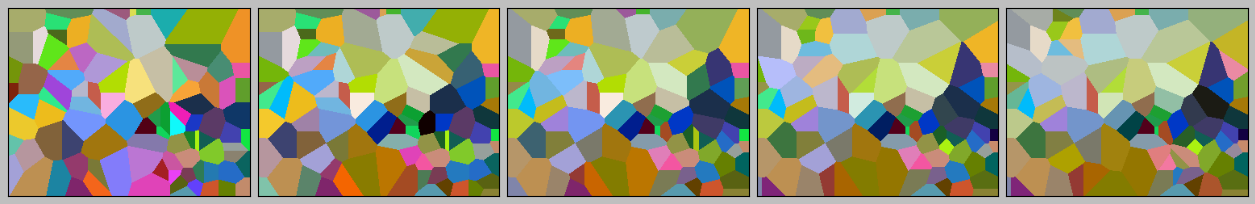

In [ ]:
show_progress_over_time((0, 100, 'ONE_POINT', 100, "RANDOM", 500), grid=(1,5))

In [ ]:
%%time
# data = run_algorithm((0, 100, "UNIFORM", 100, 'RANDOM', 500))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 3.58 µs
